# Examples of exploring ligand dissociation trajectories using pre-computed Protein-Ligand Interaction Fingerprints (IFPs)

### This example demonstrated how Protein-Ligand Interaction Fingerprints (IFPs) can be used to detect metastable states in ligand dissociation pathways generated by the RAMD method (Random Acceleration Molecular Dynamics)

    It includes:
    1. Clustering of all frames in dissociation trajectories by the PL IFP similarity ( kmean or kmode clustering can be used)
    2. Illustration of ligand dissociation pathways in a graph representation 
    3. Mapping of generated clusters on a 3D grid that can be then vizualized using some molecule vizualization software 
    (for example, PyMol, Chimera, vmd) 
    
### Script will generate:
    1. Plots schematic dissociation pathways as transitions between clusters and IFP composition of each cluster
    2. dx grid for cluster vizualization

     
### Input data required:
    You will need an IFP data frame 
        SAD_3-RAMD-03-2020.pkl (generated using trajectories from NAMD-RAMD simulations) 
        and/or unpacked archive HSP90_Gromacs.zip (generated using  trajectories obtained from Gromacs-RAMD simulations) 
    that can be downloaded from https://zenodo.org/record/3981155#.XzQEUCgzaUk 
    
    
### Packages required:
    numpy
    matplotlib
    MDAnalysis v. 20.1 or above
    pandas
    seaborn
    code is written on Python 3.x and tested on the version 3.7


### v 1.0
    06.06.2020
    Copyright (c) 2020
    Released under the EUPL Licence, v1.2 or any higher version
    
### Author: Daria Kokh 
    Daria.Kokh@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany
    


In [17]:
#from SetUp.trajectory_analysis import *
import warnings
warnings.filterwarnings("ignore")

#%load_ext autoreload
#%autoreload 2

In [18]:
import glob, os
import sys
import subprocess
import numpy as np

import pandas as pd
from pandas import ExcelFile 

from matplotlib import *
from matplotlib import cm
import matplotlib.ticker
from matplotlib import gridspec
import  pylab as plt
import seaborn
import seaborn as sns

import MDAnalysis as mda
from MDAnalysis.lib.formats.libdcd import DCDFile
from MDAnalysis.analysis import contacts,align,rms
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis.coordinates.memory import MemoryReader
import MDAnalysis.analysis.hbonds as hb

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cluster import KMeans
from matplotlib import gridspec

from scipy import stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy as clust
from scipy.spatial.distance import pdist

In [19]:
from Scripts.Clustering import *

#  I. Preprocessing
##  1. Reading  IFP data set  for one selected HSP90 compound 

    Data sets that can be analyzed:
    1. SAD_3-RAMD-03-2020.pkl - file containing IFP multiple RAMD dissociation trajectories 
    of the ligand from the HSP90 complex PDB: 5LQ9. RAMD trajectories were generated using NAMD sorfware and RAMD tcl script
    2. or data from the HSP90_Gromacs.zip archive, that contains IFP datasets of RAMD trajectories generated using Gromacs-RAMD
    for the complexes: 
           directory HSP90_Gromacs/SAD_3:     PDB ID: 5J64
           directory HSP90_Gromacs/1931144:   PDB ID: 5J86
           directory HSP90_Gromacs/1860734    PDB ID: 5LQ9
    

In [20]:
#  select comlex to be analyzed by commenting/uncommenting corresponding line
ligand =  "SAD_3"   
#ligand =  "1931144"
#ligand = "1860734"
#  select the path to the location of a pkl file to be analyzed
name_template = ligand+"*.pkl"
dir_all =  "DATA\\DATA\\HSP90_Gromacs\\"  
DIR_in = dir_all + ligand + "\\"

# here you can also select a directory to save output plots and grids
DIR_out =  DIR_in


##################################################
# readIFP database for just one ligand
####################################################

#---- read IFP data set
df_tot_org,ligandsi,new_list_col = read_databases(DIR_in,name_template)
print(df_tot_org.shape)    
#----- remove IFP that appear rarely (in less then threshold from the total number of frames in each trajectory)
df_tot_new = clean_ramd(df_tot_org,threshold = -1)
df_tot_org= df_tot_new
#---- sort resudues by number
resi_list_sorted,resi_name_list_sorted,ifp_list = separate_IFP(df_tot_org.columns.tolist())
# if Replicas are not included in the database, but should be, we will fill out Repl column
try:
    if(np.unique(df_tot_org.Repl.values) == ''):
        Repl = []
        R = 0
        start = np.argwhere(df_tot_org.time.values == 0).flatten()
        for i in range(0,df_tot_org.shape[0]): 
            if i in start: R += 1
            Repl.append("Repl_"+str(R))
        df_tot_org.Repl = Repl
except:
    pass

DATA\DATA\HSP90_Gromacs\SAD_3\SAD_3-WB_-RAMD0-300.pkl SAD_3-WB
DATA\DATA\HSP90_Gromacs\SAD_3\SAD_3-WB_-RAMD1-300.pkl SAD_3-WB
DATA\DATA\HSP90_Gromacs\SAD_3\SAD_3-WB_-RAMD3-300.pkl SAD_3-WB
DATA\DATA\HSP90_Gromacs\SAD_3\SAD_3-WB_-RAMD4-300.pkl SAD_3-WB
DATA\DATA\HSP90_Gromacs\SAD_3\SAD_3-WB_-RAMD5-300.pkl SAD_3-WB
DATA\DATA\HSP90_Gromacs\SAD_3\SAD_3-WB_-RAMD6-300.pkl SAD_3-WB
DATA\DATA\HSP90_Gromacs\SAD_3\SAD_3-WB_-RAMD7-300.pkl SAD_3-WB
(15600, 734)
(15600, 734) (15600, 734)
COM - skip no-IFP property
RGyr - skip no-IFP property
RMSDl - skip no-IFP property
RMSDp - skip no-IFP property
Repl - skip no-IFP property
Traj - skip no-IFP property
WAT - skip no-IFP property
length - skip no-IFP property
ligand - skip no-IFP property
time - skip no-IFP property
COM_x - skip no-IFP property
COM_y - skip no-IFP property
COM_z - skip no-IFP property


## 2.Cleaning dataset:
    1. Check ligand RMSD and discard trajectories where ligand readily left the pocket at the beginning of the trajectory part used for generation IFPs 
    2. Check and discard the trajectories where ligand does not leave the pocket 
    23. check  if there is a jump in the ligand position (center of mass or RMSD) in  two neighbour frames, 
    which may appear due to incomplete wrapping the system back to the box (PBC effect) 
    or when the ligand already left the pocket.
    A part of the trajectory starting from the detected jump will be removed from the dataset

too large RMSD in the start :  8.6266240349484 31.71251062152969
too small RMSD at the end:  1.4046154589981223 13.168919189333248
too large RMSD in the start :  6.275808067195629 37.40668900867031
too large RMSD in the start :  20.757945736171013 48.877031731169645
too large RMSD in the start :  8.40711484856151 31.263487534336807
too large RMSD in the start :  5.200679918217492 45.86965525064815
too large RMSD in the start :  24.32493226569968 41.96230374015606
too large RMSD in the start :  10.53505075645798 44.248478203122595


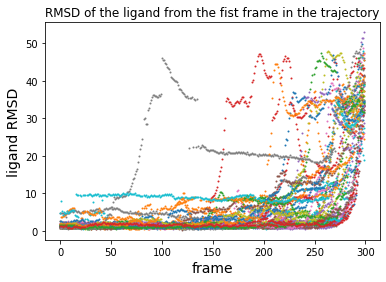

Original size of the database:  (15600, 734)  trajectories: 52
Final size of the database:  (12526, 734)


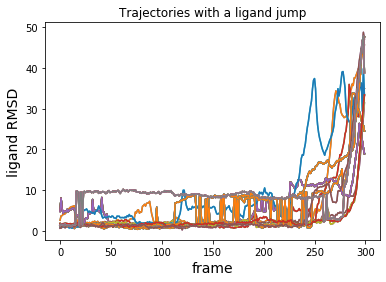

In [21]:
threshold_start_RMSD = 5
threshold_end_RMSD = 15

trj_to_discard = []
tot_traj = 0
k = 0
for j in np.unique(df_tot_org.Repl.values):
    df_tot_Repl = df_tot_org[df_tot_org.Repl == j]
    for i in np.unique(df_tot_Repl.Traj.values.astype(int)):
        df_tot_Repl_Traj = df_tot_Repl[df_tot_Repl.Traj == str(i)]
        if(df_tot_Repl_Traj.RMSDl.values[0] > threshold_start_RMSD) :
            trj_to_discard.append((j,i))
            print("too large RMSD in the start : ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
        elif (df_tot_Repl_Traj.RMSDl.values[-1] < threshold_end_RMSD) :  
            trj_to_discard.append((j,i))
            print("too small RMSD at the end: ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
        else:
            plt.plot(df_tot_Repl_Traj.RMSDl,marker='o', linestyle="",markersize=1)
            tot_traj +=1

plt.xlabel("frame",fontsize=14)
plt.ylabel("ligand RMSD",fontsize=14)
plt.title("RMSD of the ligand from the fist frame in the trajectory")
plt.show()

print("Original size of the database: ",df_tot_org.shape," trajectories:",df_tot_org[df_tot_org.time == 0].shape[0])

for j,i in trj_to_discard:
    df_tot_org = df_tot_org[~((df_tot_org.Traj == str(i)) & (df_tot_org.Repl == j))]
    
df_tot_org = remove_dissociated_parts(df_tot_org)
print("Final size of the database: ",df_tot_org.shape)

###   Plot RMSD and ligand COM for the last 300 frames in dissociation trajectories

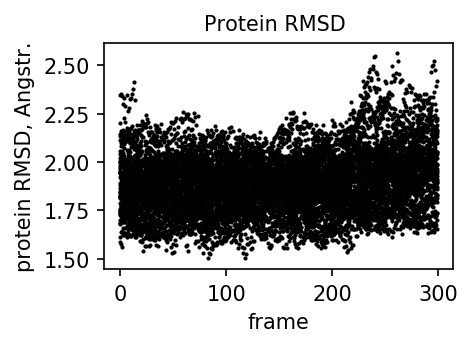

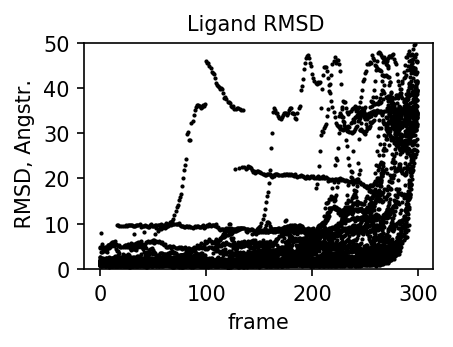

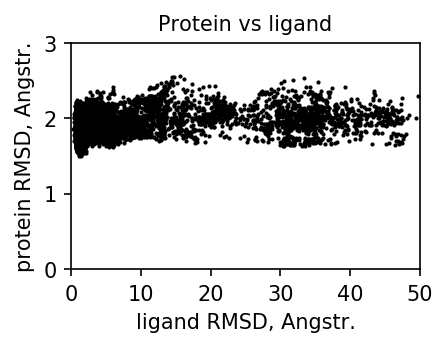

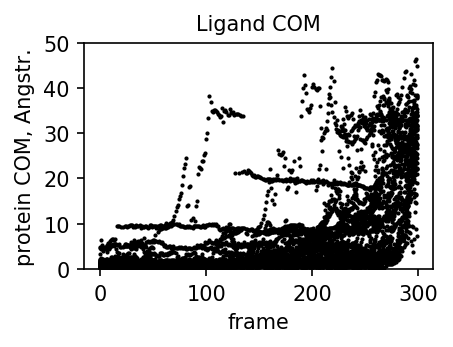

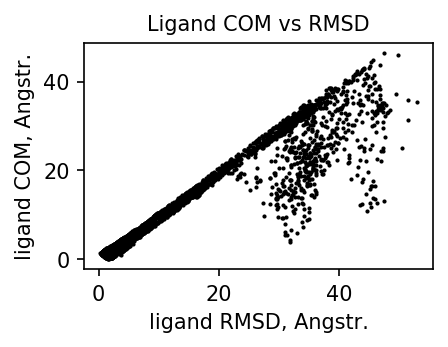

In [22]:
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.time,df_tot_org.RMSDp, s=1, color = "k")
plt.xlabel("frame",fontsize=10)
plt.ylabel("protein RMSD, Angstr.",fontsize=10)
plt.title("Protein RMSD ",fontsize=10)
plt.show()

fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.time,df_tot_org.RMSDl, s=1, color = "k")
plt.xlabel("frame",fontsize=10)
plt.ylabel(" RMSD, Angstr.",fontsize=10)
plt.title("Ligand RMSD ",fontsize=10)
plt.ylim(0,50)
plt.show()
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.RMSDl,df_tot_org.RMSDp, s=1, color = "k")
plt.ylabel("protein RMSD, Angstr.",fontsize=10)
plt.xlabel("ligand RMSD, Angstr.",fontsize=10)
plt.title("Protein vs ligand",fontsize=10)
plt.xlim(0,50)
plt.ylim(0,3)
plt.show()

dist = np.sqrt((df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])*(df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])+(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])*(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])+(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0])*(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0]))
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.time,dist, s=1, color = "k")
plt.ylabel("protein COM, Angstr.",fontsize=10)
plt.xlabel("frame",fontsize=10)
plt.title("Ligand COM",fontsize=10)
plt.ylim(0,50)
plt.show()

dist = np.sqrt((df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])*(df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])+(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])*(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])+(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0])*(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0]))
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.RMSDl,dist, s=1, color = "k")
plt.xlabel("ligand RMSD, Angstr.",fontsize=10)
plt.ylabel("ligand COM, Angstr.",fontsize=10)
plt.title("Ligand COM vs RMSD",fontsize=10)
plt.show()

 A quick overview of the IFP, unspecific contacts, and number of water molecules 

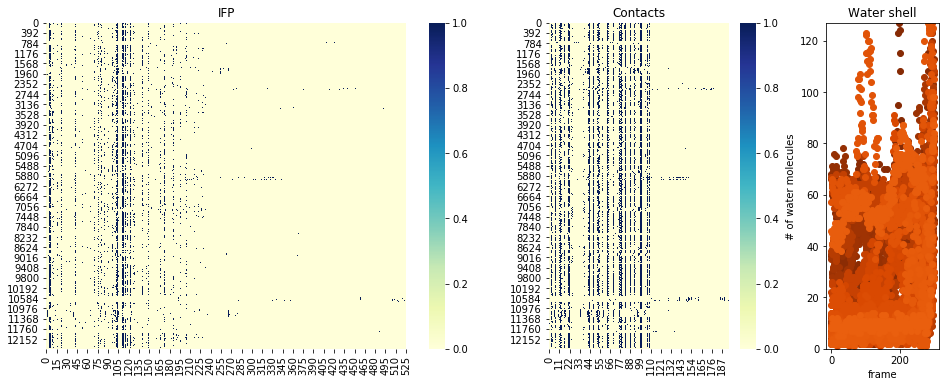

In [23]:
Plot_IFP(df_tot_org)

##   4. Select IFP by types to be used in analysis

##   3. Change residue numbering ( the first residue number in employed PDB of HSP90 is 16)

In [24]:
# --- We can Select either IFP and unspecific interactions (starting with "RE" in the pkl IFP dataset)
ifp_list = ["AR","HD","HA","HY","WB","IP","IN","RE"]
# --- Or Select IFP only-
#ifp_list = ["AR","HD","HA","HY","WB","IP","IN"]
# --- Or  only  unspecific interactions -
#ifp_list = ["RE"]
shift = 0
shift = 16 # for HSP90
columns_IFP = []
columns_IFP_renamed = {}
for c in df_tot_org.columns.values:
    if c[0:2] in ifp_list:   
        columns_IFP.append(c[:6]+str(int(c[6:])+shift))
        columns_IFP_renamed.update( {c : c[:6]+str(int(c[6:])+shift)} )
df_tot = df_tot_org.rename(columns_IFP_renamed, axis='columns')


## 5. Remove rare contacts to make dataset less noisy

In [25]:
unpickled_df=df_tot        

# remove rare contacts
df_ext = unpickled_df[columns_IFP]        
print("Original ", df_ext.shape)
columns_IFP_reduced = np.asarray(columns_IFP)[df_ext.sum().values > 0]
df_ext = df_ext[columns_IFP_reduced]   
columns_IFP = columns_IFP_reduced
print("Reduced", df_ext.shape)
        
X = df_ext.values
if "WAT" in unpickled_df.columns.values:
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","WAT","RGyr","COM_x","COM_y","COM_z","COM"]
else:
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","RGyr","COM_x","COM_y","COM_z","COM"]
df_ext[add_columns] = unpickled_df[add_columns]

Original  (12526, 721)
Reduced (12526, 636)


# II. Clustering of  all snapshots by IFP  and vizualization of dissociation tarjectories
## 1. kmean (or kmodes)  clustering

In [26]:
kmodes = False
DBSCAN = False
GM = False
Frame_clusters = 8
if kmodes:
    from kmodes.kmodes import KModes
    km = KModes(n_clusters=Frame_clusters, init='Huang', n_init=2, verbose=1)
    clusters = km.fit_predict(X) 
    labels_ = km.labels_
else:
    if DBSCAN:
        from sklearn.cluster import DBSCAN
        km = DBSCAN(eps=3, min_samples=2).fit(X)
    elif GM: 
        from sklearn import mixture
        gmm = mixture.GaussianMixture(n_components=Frame_clusters, covariance_type='full').fit(X)
        labels_ = gmm.predict(X)
    else:
        km = KMeans(n_clusters=Frame_clusters, random_state=0).fit(X)
        labels_ = km.labels_

labels_list = np.unique(labels_)   
df_ext["label"] = labels_
print(df_ext.shape,X.shape)


(12526, 649) (12526, 636)


## 2. We will re-lable cluster by their size for nicer representation 

In [27]:
renumber_labels = True
if renumber_labels:
    l,c = np.unique(labels_,return_counts=True)
    ln = l[np.argsort(c)]
    label_mapping= dict(zip(ln,l))
    print(label_mapping)
    new_labels = np.vectorize(label_mapping.get)(labels_)
    df_ext["label"] = new_labels
    print(np.unique(new_labels,return_counts=True))    
else:
    df_ext["label"] = labels_

{7: 0, 2: 1, 1: 2, 4: 3, 3: 4, 0: 5, 6: 6, 5: 7}
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 448,  603, 1269, 1270, 1440, 1734, 2733, 3029], dtype=int64))


## 3. Vizualization of the ligand cenetr of mass (COM) position and number of water molecules in the ligand solvation shell for each cluster

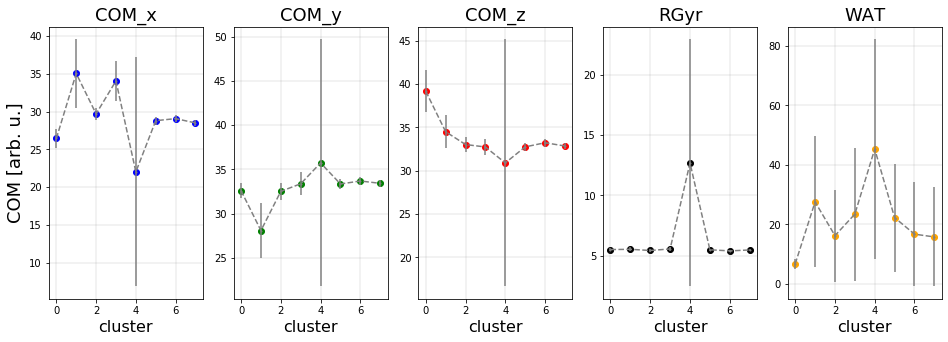

In [28]:

Plot_COM(df_ext)

##   4. Visuzalization of dissociation trajectories using a graph representation

    Dissociation pathways are shown in a graph representation derived from IFPs of the last 300 frames of each trajectory. 
    Each cluster is shown by a node with the size indicating the cluster population. 
    Nodes Ci are positioned on an increasing logarithmic scale of the average ligand COM position in the cluster 
    from the starting snapshot and the node color denotes change of the ligand RMSD in the cluster from the starting structure.
    The width of the light-orange arrows is proportional to the number of corresponding transitions 
    (Ci  -> Cj ) and (Ci  <- Cj ) between two nodes Ci and Cj 
    and the gray arrows indicate the total flow between two nodes 
    (i.e. transitions (Ci  -> Cj )-(Ci  <- Cj )). (D, E, F) - IFP composition of each cluster. 
    
    Transition density and Flow plots illustrate the number of (Ci  -> Cj ) transitions and nett flow, respectively

cluster  0 STD of COM:  1.2065610218470997 0.8093382698866206 2.4218691227931037 STD of RMSD:  2.600152614627024 Water: []
cluster  1 STD of COM:  4.517618530565066 3.1163556606649716 1.9073173993396513 STD of RMSD:  3.5693656985365054 Water: []
cluster  2 STD of COM:  0.7602925859213041 0.9596304829479622 0.8786971126564417 STD of RMSD:  0.988302486640412 Water: []
cluster  3 STD of COM:  2.667868198065668 1.2880779201269377 0.9354396723810131 STD of RMSD:  2.6550138705961905 Water: []
cluster  4 STD of COM:  15.168390422257616 13.996625073529747 14.243251308986228 STD of RMSD:  9.431506527084087 Water: []
cluster  5 STD of COM:  0.5133690171182475 0.5143478676192279 0.5047355899362586 STD of RMSD:  0.42584278033364986 Water: []
cluster  6 STD of COM:  0.4982994467336067 0.39796576166667386 0.4606993624592317 STD of RMSD:  0.30421300355407405 Water: []
cluster  7 STD of COM:  0.44375186088370444 0.42491880334726695 0.3782689391445778 STD of RMSD:  0.38139583653128933 Water: []
COM dis

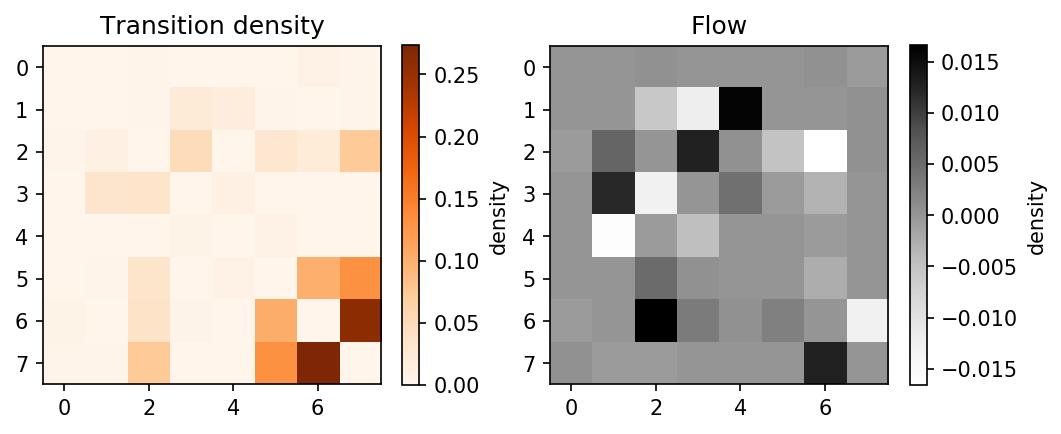

COLORS (i.e. averade RMSD) to be used in each cluster for plotting:  [20. 30.  0. 10. 55.  0.  0.  0.]


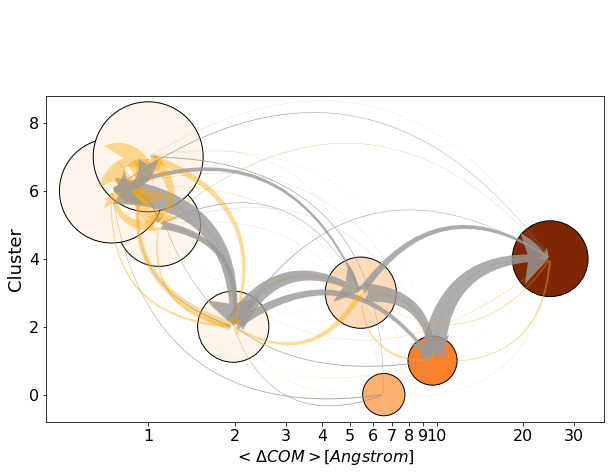

In [29]:
ligand_show =  [] 
out_name = "cluster-traj.png"
arg_Label_list = plot_graph_COM(df_ext,DIR_out+out_name,ligand_show,draw_round = False, water=False)


##   5. Vizualization of the cluster composition

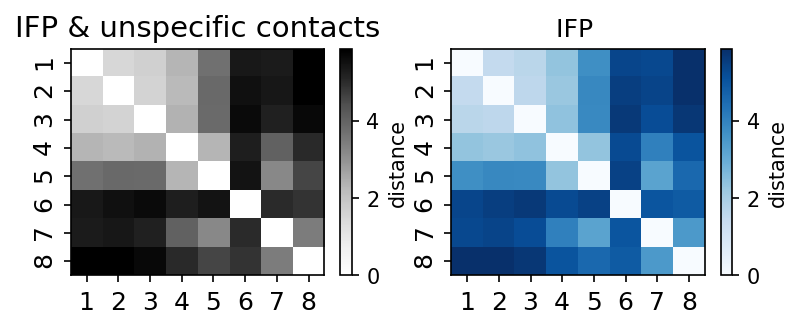

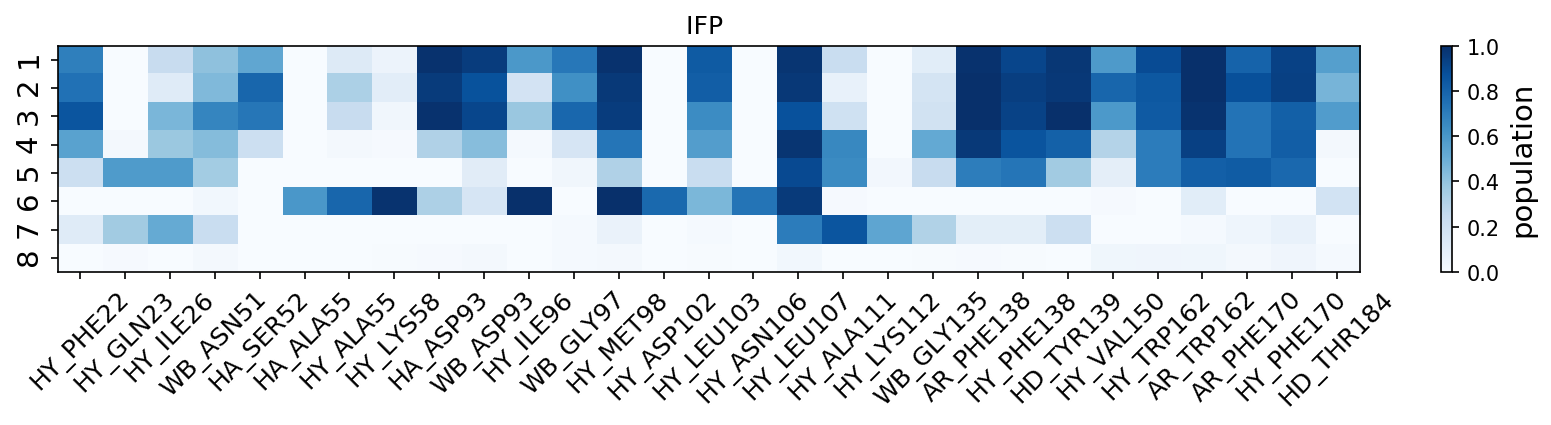

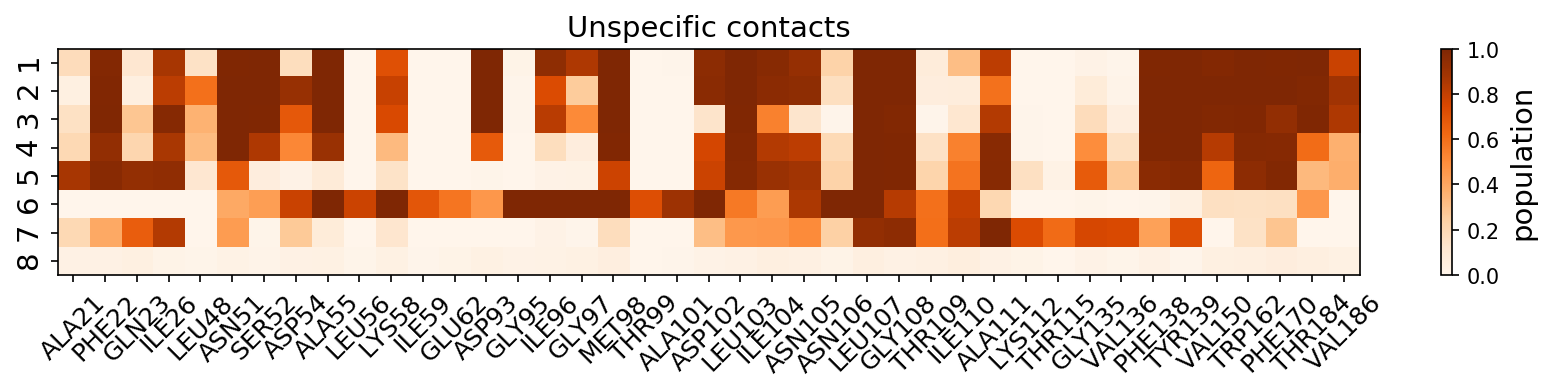

In [30]:

threshold = 0.5

sorted_labels = labels_list[arg_Label_list]

file_save = DIR_out+"cluster_traj-population-img.png"
df_ext_ligand = df_ext[df_ext.ligand.isin([ligand])]

p = []
for c in columns_IFP: p.append(c[6:])
indx = np.argsort(np.asarray(p).astype(float))  

ar = np.zeros((len(sorted_labels),indx.shape[0]), dtype = float)
for i,l in enumerate(sorted_labels):
    ar[i] = df_ext[df_ext.label == l][columns_IFP].mean().values[indx]
    
br = np.max(ar,axis=0)
indx_threshold = np.where(br > threshold)[0]
col_threshold = np.asarray(columns_IFP)[indx][indx_threshold]

RE_col_threshold = []
IFP_col_threshold = []
RE_indx_threshold = []
IFP_indx_threshold = []

for i,c in enumerate(col_threshold):
    if c[:2] == "RE": 
        RE_col_threshold.append(c[3:])
        RE_indx_threshold.append(i)
    else: 
        IFP_col_threshold.append(c)
        IFP_indx_threshold.append(i)
IFP_indx_threshold = np.asarray(IFP_indx_threshold)
IFP_col_threshold = np.asarray(IFP_col_threshold)
RE_col_threshold = np.asarray(RE_col_threshold)
RE_indx_threshol = np.asarray(RE_indx_threshold)

#--- compute and show 2D distance matrics of IFPs
e_dist = np.zeros((ar.shape[0],ar.shape[0]))
e_dist_ifp = np.zeros((ar.shape[0],ar.shape[0]))
for i,ar1 in enumerate(ar):
    for j,ar2 in enumerate(ar):
        e_dist[i,j] = numpy.linalg.norm(ar1-ar2)
        e_dist_ifp[i,j] = numpy.linalg.norm(ar1[indx]-ar2[indx])
    

fig = plt.figure(figsize = (6, 2),facecolor='w',dpi=150)
ax = plt.subplot(1,2,1)
ec=plt.imshow(e_dist,cmap='Greys',aspect = "auto")
plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=12)
plt.xticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),fontsize=12)
cbar = plt.colorbar(ec)
cbar.set_label('distance')
ax.set_title("IFP & unspecific contacts",fontsize=14)
ax = plt.subplot(1,2,2)
ec=plt.imshow(e_dist,cmap='Blues',aspect = "auto")
plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=12)
plt.xticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),fontsize=12)
ax.set_title("IFP ")
cbar = plt.colorbar(ec)
cbar.set_label('distance')
plt.show()


# show IFP composition of the generated clusters
file_save = DIR_out+"cluster_traj-population-IFP-img.png"
fig = plt.figure(figsize = (14, int(Frame_clusters/3.1)),facecolor='w',dpi=150)
ax = plt.subplot(1,1,1)
max_ar = np.amax(ar[:,indx_threshold][:,IFP_indx_threshold])
ec=plt.imshow(ar[:,indx_threshold][:,IFP_indx_threshold],cmap='Blues',aspect = "auto")
plt.xticks(range(0,col_threshold[IFP_indx_threshold].shape[0]),col_threshold[IFP_indx_threshold] ,rotation=45,fontsize=12)
plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),fontsize=14,rotation=90)
ax.set_title("IFP ")
cbar = plt.colorbar(ec)
cbar.set_label('population',fontsize=14)

if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
else: plt.show()

# show unspecific contact contribution is they are included in clustering
if "RE" in ifp_list: 
    file_save = DIR_out+"cluster_traj-population-RE-img.png"
    fig = plt.figure(figsize = (14, int(Frame_clusters/3.1)),facecolor='w',dpi=150)
    ax = plt.subplot(1,1,1)
    ec=plt.imshow(ar[:,indx_threshold][:,RE_indx_threshold],cmap='Oranges',aspect = "auto")
    plt.xticks(range(0,col_threshold[RE_indx_threshold].shape[0]),RE_col_threshold ,rotation=45,fontsize=12)
    plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=14)
    ax.set_title("Unspecific contacts",fontsize=14)
    cbar = plt.colorbar(ec)
    cbar.set_label('population',fontsize=14)
    
    if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
    else: plt.show()


## 6. Mapping clasters on a 3D grid using ligand COM 

In [31]:
for k in np.unique(df_ext.label.values):
    if len(ligand_show) > 0:
        df_cl = df_ext[df_ext.ligand == ligand_show[0]]
    else: df_cl = df_ext
    d_cluster = df_cl[df_cl.label == k]
    if d_cluster.shape[0] > 20:
        Map_3D_grid(d_cluster,DIR_out+"cluster-05-"+str(k)+".dx")
